# Simple audio recognition: Recognizing keywords

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [1]:
import utils
from utils.audio_utils import *
from utils.audio_models import *
from utils.keras_utils import *

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


## Speech dataset (2.11 GB uncompressed)
#### http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)

# Speech dataset (2.11 GB uncompressed)
# http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

# if not data_dir.exists():
#     tf.keras.utils.get_file(
#     'mini_speech_commands.zip',
#     origin="http://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
#     extract=True,
#     cache_dir='.', cache_subdir='data')

# Experiment with different audio features

#### MFCC • A highly engineered preprocessing of the audio waveform

MFCC computation involves 6 steps

1. Segment the signal into short frames
2. For each frame: calculate its power spectrum
3. Apply a Mel filterbank to the power spectrum
    • sum the energy within each filter.
    

    We take clumps of periodogram bins and sum them up to get an
    idea of how much energy there exists in each region
    • This is performed using a Mel filterbank
    • First Mel filter is very narrow: to get an idea of how much energy there
    is around 0 Hertz
    • Filters get wider as frequencies get higher: we become less
    concerned about variations (Mel scale tells us how to space filterbanks)
4. Take the logarithm of all filterbank energies
5. Take the DCT of the log filterbank energies - DCT decorrelates filterbank energies
6. Keep DCT coefficients 2-13, discard the others

## File signal example and feature vector calculation

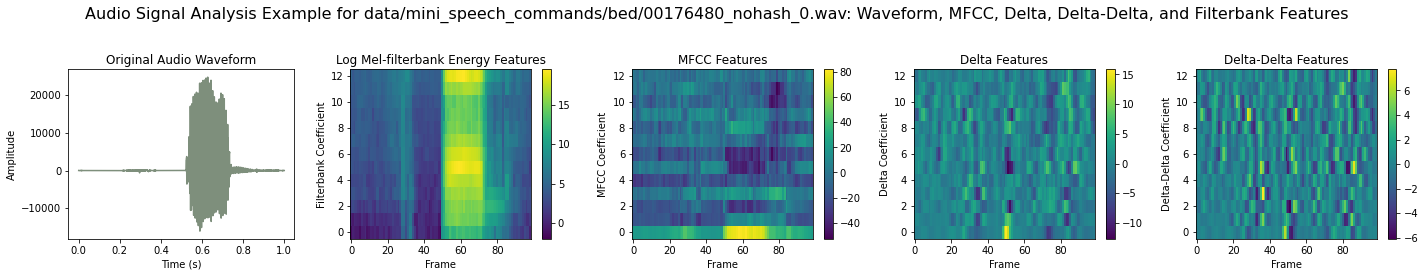

In [3]:
# Load an example audio file for inference
data_dir = 'data/mini_speech_commands/bed/'
file = '00176480_nohash_0.wav'
file_path = os.path.join(data_dir, file)
rate, example_signal = wavfile.read(file_path)

sig_ds, rate_ds, feature_dicts = example_feature_vectors(file_path, 1)

# Separate dictionaries for each feature type
signal_dict = feature_dicts['signal_dict']
mfcc_dict = feature_dicts['mfcc_dict']
delta_dict = feature_dicts['delta_dict']
delta_delta_dict = feature_dicts['delta_delta_dict']
fbank_dict = feature_dicts['fbank_dict']
full_feature_vector_dict = feature_dicts['full_feature_vector_dict']

plot_example(sig_ds, rate_ds, fbank_dict,mfcc_dict, delta_dict, delta_delta_dict, file_path)

## Calculate the feature vectors of words

In [4]:
# Load the feature vectors from the saved pickle file
load_path = 'feature_data/ten_words.pkl'
with open(load_path, 'rb') as file:
    signal_ds, spectro_ds, mfcc_ds, delta_ds, delta_delta_ds, full_feature_vector_ds = pickle.load(file)


In [5]:
# Convert each dictionary value from list to array
convert_to_arrays(signal_ds)
convert_to_arrays(spectro_ds)
convert_to_arrays(mfcc_ds)
convert_to_arrays(delta_ds)
convert_to_arrays(delta_delta_ds)
convert_to_arrays(full_feature_vector_ds)

# Add channel axis, N, 99, 13, 1. Where 1 is the channel of spectrogram intensity
add_new_axis(signal_ds)
add_new_axis(spectro_ds)
add_new_axis(mfcc_ds)
add_new_axis(delta_ds)
add_new_axis(delta_delta_ds)
# Add channel axis, N, 99, 43, 1. Where 1 is the channel of spectrogram intensity
add_new_axis(full_feature_vector_ds)

# Investigate recent/new ANN architectures

### Inception

In [6]:
# Split in train and test
X_train, X_test, y_train, y_test, sig_train, sig_test, one_hot_labels, one_hot_encoder, y_decoded_train, y_decoded_test = train_test_creation(mfcc_ds, signal_ds)

# Specify the amount of padding for each dimension
pad_width = ((0, 0), (0, 1), (3, 4), (0, 0))

# Pad the array with zeros
X_train = np.pad(X_train, pad_width, mode='constant', constant_values=0)
X_test = np.pad(X_test, pad_width, mode='constant', constant_values=0)

# Perform data augmentation
X_train_augmented = augment_data(X_train, augmentation_percentage=0.2)

# Normalize the data, cache it and batch it
train_dataset, test_dataset, img_shape = normalize_cache_batch(X_train_augmented, X_test, y_train, y_test, cache_batch=True)

# Analyze example audio file from X_train

In [7]:
import numpy as np
import sounddevice as sd

# Assuming audio_array is an array of dtype=object containing audio data
audio_array = sig_train[0]  # Replace sig_train[2] with your audio data

# Convert audio_array to a numpy array of type int16
audio_array = np.array(audio_array[0], dtype=np.int16)

# Play audio
sd.play(audio_array, samplerate=16000)
sd.wait()  # Wait until playback is finished

Y_pred_decoded_labels_inc = one_hot_encoder.inverse_transform(y_train[0].reshape(1, -1))

print("OneHotEncoded:", y_train[0])
print("Decoded:", Y_pred_decoded_labels_inc)

OneHotEncoded: [0. 0. 0. 0. 0. 1. 0. 0. 0.]
Decoded: [['happy']]


In [11]:
print('TRAIN SET, images: {}'.format(X_train_augmented.shape))
print('TRAIN SET, labels: {}'.format(y_train.shape))
train_length = y_train.shape[0]

print('TEST SET, images: {}'.format(X_test.shape))
print('TEST SET, labels: {}'.format(y_test.shape))
test_length = y_test.shape[0]

TRAIN SET, images: (11340, 100, 20, 1)
TRAIN SET, labels: (11340, 9)
TEST SET, images: (2835, 100, 20, 1)
TEST SET, labels: (2835, 9)


## Show some examples

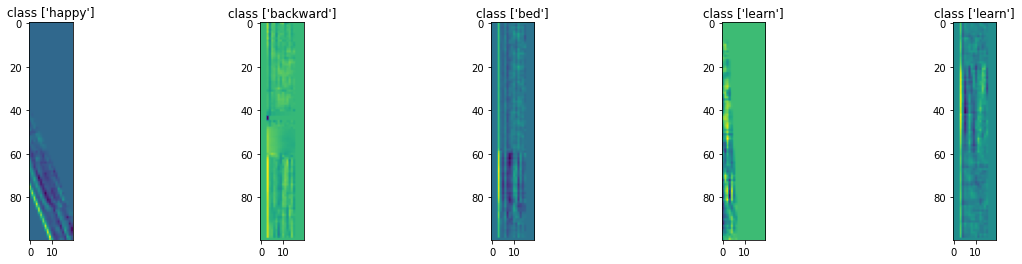

In [12]:
plt.figure(figsize=[20, 4])
plt.subplot(1, 10, 1)

for i in range(5):
    plt.subplot(1, 5, i + 1, label="Subplot {}".format(i + 1))
    image = X_train_augmented[i, :, :, :]
    plt.imshow(image.tolist())
    label = y_decoded_train[i]
    plt.title('class ' + str(label))

plt.show()

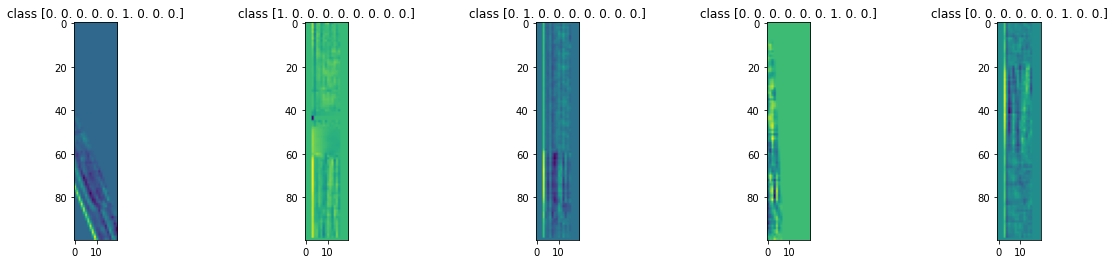

In [13]:
plt.figure(figsize=[20, 4])
plt.subplot(1, 10, 1)

for i in range(5):
    plt.subplot(1, 5, i + 1, label="Subplot {}".format(i + 1))
    image = X_train_augmented[i, :, :, :]
    plt.imshow(image.tolist())
    label = y_train[i]
    plt.title('class ' + str(label))

plt.show()

## [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) that generates batches of tensor image data.

In [14]:
datagen_train = ImageDataGenerator()

In [15]:
datagen_test = ImageDataGenerator()

In [16]:
batch_size = 32
train_steps = int(np.ceil(train_length/batch_size))
test_steps = int(np.ceil(test_length/batch_size))

# Inception network

In a pure Inception network, there are two different block types: the Inception blocks and the Reduction blocks.

Inception-v4 is composed of three Inception blocks, two Reduction ones and an initial stem block.

## 1 - Inception-v4 blocks
### 1.1 - Convolutional and batch normalization helper function
First of all, here below is implemented the ``conv2d_bn`` helper function that you will use in all the blocks of the Inception v4 network.

Use the following structure:
- CONV2D with $F$ filters of shape ($h$, $w$), stride of ($s_1$, $s_2$).
- BatchNorm, normalizing the 'channels' axis.  
- ReLU activation function.

In [17]:
# FUNCTION: conv2d_bn block

def conv2d_bn(X_input, filters, kernel_size, strides, padding='same', activation=None,
              name=None):
    """
    Implementation of a conv block as defined above

    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- integer, defining the number of filters in the CONV layer
    kernel_size -- (f1, f2) tuple of integers, specifying the shape of the CONV kernel
    s -- integer, specifying the stride to be used
    padding -- padding approach to be used
    name -- name for the layers

    Returns:
    X -- output of the conv2d_bn block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'conv_'
    bn_name_base = 'bn_'

    X = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides,
               padding = padding, name = conv_name_base + name,
               kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis = 3, name = bn_name_base + name)(X)
    if activation is not None:
        X = Activation(activation)(X)
    return X

## 1.2 - The stem block

In [18]:
def stem_block(X_input):
    X = conv2d_bn(X_input, filters=32, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu', name='stem_1th')
    X = conv2d_bn(X, filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', name='stem_2nd')
    X = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='stem_pool')(X)
    return X

## 1.3 - The Inception-A block

In [19]:
def inception_a_block(X_input, base_name):
    branch1 = AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='same', name=base_name+'_branch_1_1')(X_input)
    branch1 = conv2d_bn(branch1, filters=96, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', name=base_name+'_branch_1_2')

    branch2 = conv2d_bn(X_input, filters=96, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', name=base_name+'_branch_2_1')

    branch3 = conv2d_bn(X_input, filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', name=base_name+'_branch_3_1')
    branch3 = conv2d_bn(branch3, filters=96, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', name=base_name+'_branch_3_2')

    branch4 = conv2d_bn(X_input, filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', name=base_name+'_branch_4_1')
    branch4 = conv2d_bn(branch4, filters=96, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', name=base_name+'_branch_4_2')
    branch4 = conv2d_bn(branch4, filters=96, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', name=base_name+'_branch_4_3')

    X = concatenate([branch1, branch2, branch3, branch4], axis=3)
    return X


## 1.4 - The Reduction-A block

In [20]:
def reduction_a_block(X_input):
    branch1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='ra_branch_1_1')(X_input)
    branch2 = conv2d_bn(X_input, filters=384, kernel_size=(2, 2), strides=(2, 2), padding='valid', activation='relu', name='ra_branch_2_1')
    branch3 = conv2d_bn(X_input, filters=192, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu', name='ra_branch_3_1')
    branch3 = conv2d_bn(branch3, filters=224, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu', name='ra_branch_3_2')
    branch3 = conv2d_bn(branch3, filters=256, kernel_size=(2, 2), strides=(2, 2), padding='valid', activation='relu', name='ra_branch_3_3')

    X = concatenate([branch1, branch2, branch3], axis=3)
    return X

## 1.5 - Network construction

Inception-v4 network

Add a ``Flatten`` layer after the last ``AveragePooling2D`` layer.

In [21]:
def Inceptionv4(input_shape, num_classes, activation_function):
    X_input = Input(input_shape)
    X = stem_block(X_input)
    X = inception_a_block(X, 'a1')
    X = reduction_a_block(X)

    # Adjust the pooling layer to ensure valid dimensions
    X = AveragePooling2D((1, 1), name='avg_pool')(X)
    
    # Flatten and Dense layers
    X = Flatten()(X)
    X = Dropout(0.2)(X)
    
    # Update the number of units and activation function for multiclass
    X = Dense(num_classes, activation=activation_function, name='fc')(X)

    model = Model(inputs=X_input, outputs=X, name='Inceptionv4_multiclass')
    
    return model

## 2 - Network training

In [22]:
num_labels = len(one_hot_labels)
activation_function = 'softmax'
loss_multi = 'categorical_crossentropy'

model = Inceptionv4(input_shape = (100, 20, 1), num_classes = num_labels, activation_function = activation_function)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)

In [23]:
# Create a callback for early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

# Assuming `model` is already defined elsewhere

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Assuming you have defined `datagen_train`, `datagen_test`, `X_train`, `Y_train`, `X_test`, `Y_test`, `batch_size`, `train_steps`, and `test_steps` elsewhere

train_dataset = datagen_train.flow(X_train_augmented, y_train, batch_size=batch_size, shuffle=True)
test_dataset = datagen_test.flow(X_test, y_test, batch_size=batch_size, shuffle=True)

# Train the model with early stopping callback
model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=20,
          steps_per_epoch=train_steps,
          validation_steps=test_steps,
          callbacks=[early_stopping_callback])

Model: "Inceptionv4_multiclass"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 20, 1)]         0         []                            
                                                                                                  
 conv_stem_1th (Conv2D)      (None, 49, 9, 32)            320       ['input_1[0][0]']             
                                                                                                  
 bn_stem_1th (BatchNormaliz  (None, 49, 9, 32)            128       ['conv_stem_1th[0][0]']       
 ation)                                                                                           
                                                                                                  
 activation (Activation)     (None, 49, 9, 32)            0         ['bn_stem

                                                                     'activation_8[0][0]']        
                                                                                                  
 conv_ra_branch_3_1 (Conv2D  (None, 23, 3, 192)           295104    ['concatenate[0][0]']         
 )                                                                                                
                                                                                                  
 bn_ra_branch_3_1 (BatchNor  (None, 23, 3, 192)           768       ['conv_ra_branch_3_1[0][0]']  
 malization)                                                                                      
                                                                                                  
 activation_10 (Activation)  (None, 23, 3, 192)           0         ['bn_ra_branch_3_1[0][0]']    
                                                                                                  
 conv_ra_b

In [25]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset, steps=test_steps)
print('Test Loss = {:.5f}'.format(test_loss))
print('Test Accuracy = {:.2f}%'.format(test_accuracy * 100))


89/89 [==============================] - 2s 28ms/step - loss: 0.6874 - accuracy: 0.8832
Test Loss = 0.68735
Test Accuracy = 88.32%


89/89 [==============================] - 3s 27ms/step


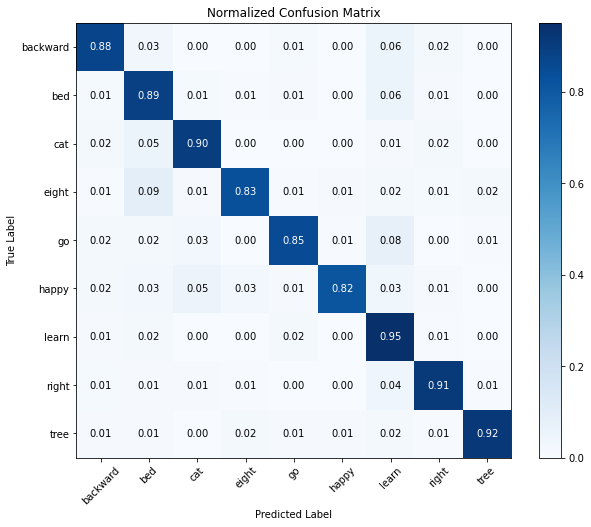

Classification Report:
               precision    recall  f1-score   support

    backward       0.90      0.88      0.89       322
         bed       0.79      0.89      0.83       324
         cat       0.88      0.90      0.89       292
       eight       0.93      0.83      0.88       323
          go       0.92      0.85      0.88       302
       happy       0.96      0.82      0.88       293
       learn       0.76      0.95      0.84       323
       right       0.91      0.91      0.91       306
        tree       0.97      0.92      0.94       350

    accuracy                           0.88      2835
   macro avg       0.89      0.88      0.88      2835
weighted avg       0.89      0.88      0.88      2835

Memory Allocation: 1052.67 MB
Memory Usage: 69.20


In [30]:
X_test = X_test.astype('float32')  # Convert to float32

# Make predictions on the test set
y_pred = model.predict(X_test)

# Decode one-hot encoded labels
y_pred_decoded_labels = one_hot_encoder.inverse_transform(y_pred)
y_test_decoded_labels = one_hot_encoder.inverse_transform(y_test)

# Get unique labels for setting tick labels
labels = np.unique(np.concatenate((y_test_decoded_labels, y_pred_decoded_labels)))

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_decoded_labels, y_pred_decoded_labels)

# Normalize confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with annotated values
plt.figure(figsize=(10, 8))  # Larger plot size
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('Normalized Confusion Matrix')
plt.colorbar()

# Set tick labels
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Add annotations
thresh = conf_matrix_normalized.max() / 2.  # Threshold for text color
for i in range(conf_matrix_normalized.shape[0]):
    for j in range(conf_matrix_normalized.shape[1]):
        plt.text(j, i, format(conf_matrix_normalized[i, j], '.2f'),
                 ha="center", va="center",
                 color="white" if conf_matrix_normalized[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
class_report = classification_report(y_test_decoded_labels, y_pred_decoded_labels)
print("Classification Report:\n", class_report)

# Memory Allocation and Usage
process = psutil.Process(os.getpid())
print(f"Memory Allocation: {process.memory_info().rss / (1024 ** 2):.2f} MB")
print(f"Memory Usage: {psutil.virtual_memory().percent:.2f}")

In [31]:
# Save the trained model in the recommended format
model.save('models/Inception/Inception_model.keras')

# Save the label encoder
joblib.dump(one_hot_encoder, 'models/Inception/label_encoder_Inception.pkl')

['models/Inception/label_encoder_Inception.pkl']